In [6]:
from __future__ import print_function, division
import os
import torchvision
import torch
from skimage import io, transform
import numpy as np
from torchvision import transforms, utils
import torch.nn as nn
import cv2
import matplotlib.pyplot as plt

from torchvision.utils import save_image

In [2]:
class MFFNet(torch.nn.Module):
    def __init__(self):
        super(MFFNet, self).__init__()
        
        self.conv1 = ConvLayer(4, 32, kernel_size=9, stride=1)
        self.in1 = torch.nn.InstanceNorm2d(32, affine=True)
        self.conv2 = ConvLayer(32, 64, kernel_size=3, stride=2)
        self.in2 = torch.nn.InstanceNorm2d(64, affine=True)
        self.conv3 = ConvLayer(64, 128, kernel_size=3, stride=2)
        self.in3 = torch.nn.InstanceNorm2d(128, affine=True)
        # Residual layers
        self.res1 = ResidualBlock(128)
        self.res2 = ResidualBlock(128)
        self.res3 = ResidualBlock(128)
        self.res4 = ResidualBlock(128)
        self.res5 = ResidualBlock(128)
        self.res6 = ResidualBlock(128)
        self.res7 = ResidualBlock(128)
        self.res8 = ResidualBlock(128)
        self.res9 = ResidualBlock(128)
        self.res10 = ResidualBlock(128)
        self.res11 = ResidualBlock(128)
        self.res12 = ResidualBlock(128)
        self.res13 = ResidualBlock(128)
        self.res14 = ResidualBlock(128)
        self.res15 = ResidualBlock(128)
        self.res16 = ResidualBlock(128)
        
        self.deconv1 = UpsampleConvLayer(128*2, 64, kernel_size=3, stride=1, upsample=2)
        self.in4 = torch.nn.InstanceNorm2d(64, affine=True)
        self.deconv2 = UpsampleConvLayer(64*2, 32, kernel_size=3, stride=1, upsample=2)
        self.in5 = torch.nn.InstanceNorm2d(32, affine=True)
        self.deconv3 = ConvLayer(32*2, 3, kernel_size=9, stride=1)

        self.relu = torch.nn.ReLU()
    
    def forward(self, X):
        o1 = self.relu(self.conv1(X))
        o2 = self.relu(self.conv2(o1))
        o3 = self.relu(self.conv3(o2))

        y = self.res1(o3)
        y = self.res2(y)
        y = self.res3(y)
        y = self.res4(y)
        y = self.res5(y)
        y = self.res6(y)
        y = self.res7(y)
        y = self.res8(y)
        y = self.res9(y)
        y = self.res10(y)
        y = self.res11(y)
        y = self.res12(y)
        y = self.res13(y)
        y = self.res14(y)
        y = self.res15(y)
        y = self.res16(y)
        
        in1 = torch.cat( (y, o3), 1 )
        y = self.relu(self.deconv1(in1))
        in2 = torch.cat( (y, o2), 1 )
        y = self.relu(self.deconv2(in2))
        in3 = torch.cat( (y, o1), 1 )
        y = self.deconv3(in3)
        
        return y

class ConvLayer(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride):
        super(ConvLayer, self).__init__()
        reflection_padding = kernel_size // 2
        self.reflection_pad = torch.nn.ReflectionPad2d(reflection_padding)
        self.conv2d = torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride)
    
    def forward(self, x):
        out = self.reflection_pad(x)
        out = self.conv2d(out)
        return out

class ResidualBlock(torch.nn.Module):
    
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = ConvLayer(channels, channels, kernel_size=3, stride=1)
        self.in1 = torch.nn.InstanceNorm2d(channels, affine=True)
        self.conv2 = ConvLayer(channels, channels, kernel_size=3, stride=1)
        self.in2 = torch.nn.InstanceNorm2d(channels, affine=True)
        self.relu = torch.nn.ReLU()
    
    def forward(self, x):
        residual = x
        out = self.relu(self.conv1(x))
        out = self.conv2(out)
        out = out + residual
        return out


class UpsampleConvLayer(torch.nn.Module):
    
    def __init__(self, in_channels, out_channels, kernel_size, stride, upsample=None):
        super(UpsampleConvLayer, self).__init__()
        self.upsample = upsample
        reflection_padding = kernel_size // 2
        self.reflection_pad = torch.nn.ReflectionPad2d(reflection_padding)
        self.conv2d = torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride)
    
    def forward(self, x):
        x_in = x
        if self.upsample:
            x_in = torch.nn.functional.interpolate(x_in, mode='nearest', scale_factor=self.upsample)
        out = self.reflection_pad(x_in)
        out = self.conv2d(out)
        return out

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
imageFilter = MFFNet()

model_name = 'MFF-net'
imageFilter.load_state_dict( torch.load('../trained_model/%s.ckpt'%(model_name)) )
imageFilter = imageFilter.to(device).float()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 1536, 2048])


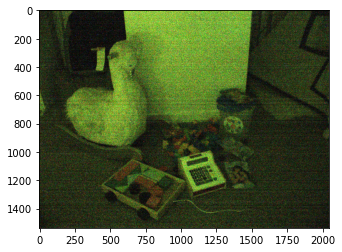

In [8]:
data_root = 'test'
out_root = 'output'
if not os.path.exists(out_root):
    os.mkdir(out_root)

for seq in range(1,2):#1,6
    # input rgb image is obtained from demosaicing the raw (no other manipulation)
    # saved in 16-bit TIFF image
    file = ('rgb_%s.tiff' % (seq) )
    filename = os.path.join( data_root, file )
#     inputs = io.imread(filename) / 65535
    inputs = io.imread(filename)
    plt.imshow(inputs)

    file = ('guide_%s.bmp' % (seq) )
    filename = os.path.join( data_root, file )
    guided = io.imread(filename) / 255

    guided = guided[:,:,0]+guided[:,:,1]+guided[:,:,2]
    inputs = (inputs*80)**0.4
    inputs = np.concatenate((inputs, guided[:,:,None]), 2)
    inputs = np.transpose(inputs,(2,0,1))
    inputs = torch.from_numpy(inputs)
    inputs = inputs[None,:,:,:].float()

    with torch.no_grad():
        inputs = inputs.to(device) 
        outputs = imageFilter(inputs)
    outputs[outputs>1] = 1
    outputs[outputs<0] = 0    

    # the parameter for color balance and brightness should be tuned for different scenes
    outputs[0,0,:,:] = outputs[0,0,:,:]*1.1*1.5
    outputs[0,1,:,:] = outputs[0,1,:,:]*1*1.5
    outputs[0,2,:,:] = outputs[0,2,:,:]*1.5*1.5
    
    print(outputs.shape)

#     save_image(outputs[0,:,:,:], '%s/out_%s.png' % (out_root, seq))
#     save_image(inputs[0,0:3,:,:], '%s/inp_%s.png' % (out_root, seq))